In [46]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

import warnings

In [26]:
# testing file
# file = xr.open_dataset('/Users/victoriaford/Downloads/CWOP_AP153.nc')
file = xr.open_dataset('train_files/CWOP_AP153.nc')
df = file.to_dataframe()

In [31]:
def qaqc_dist_gaps_part1(df, verbose=True):
    """
    Part 1 / monthly check
        - compare anomalies of monthly median values
        - standardize against interquartile range
        - compare stepwise from the middle of the distribution outwards
        - asymmetries are identified and flagged if severe
    Goal: identifies individual suspect observations and flags the entire month  
    """
    
    # in order to grab the time information more easily -- would prefer not to do this
    df = df.reset_index() 
    df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
    df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable
    
    # calculate monthly medians
    df_anom = df.sub(df.resample('M', on='time').transform('median', numeric_only=True))
    df_anom['time'] = df['time'] # add time column back in to do quantiles

    # standardize against calendar-month IQR range
    df_q1 = df_anom.resample('M', on='time').transform('quantile', 0.25, numeric_only=True)
    df_q3 = df_anom.resample('M', on='time').transform('quantile', 0.75, numeric_only=True)
    df_iqr = df_q3 - df_q1
    df_anom_iqr = df_anom / df_iqr
    
    # run through every var, excluding qaqc/duration/method vars
    vars_to_remove = ['index','station','qc', 'duration', 'method', 'lat', 'lon', 'elevation', 'time', 'month', 'year'] # list of var substrings to exclude if present in var
    vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
    
    for var in vars_to_check:
        # add _eraqc column for each variable
        df[var+'_eraqc'] = np.nan # default value of nan
        
        # "inflated to 4°C or hPa for those months with very small IQR"
        # accounts for any seasonal cycle in variance
        small_iqr_var_check = ['tas', 'tdps', 'tdps_derived', 'ps', 'psl', 'psl_altimeter', 'ps_derived']
        if var in small_iqr_var_check:
            if (np.abs(df_anom_iqr[var].max()) + np.abs(df_anom_iqr[var].min())) < 4:
                if verbose:
                    print('small var check')
                df_anom_iqr[var] = np.linspace(-2, 2, len(df)) # unsure this is the correct way to do this - come back

        # standardized anomalies are ranked (necessary?) and calculate median
        std_med = df_anom_iqr.median() # will be 0 if inflated to range of 4

        # add standardized anomaly median to IQR-standardized data
        df_std_med = df_anom_iqr + std_med
        df_std_med['time'] = df['time'] # add time columns back in... again
        df_std_med['year'] = df['year']
        df_std_med['month'] = df['month']

        # identify where any obs are +/- 5 IQR away from standardized anomaly median
        if len(df_std_med.loc[np.abs(df_std_med[var]) > 5]) != 0:

            bad_idxs = df_std_med.loc[np.abs(df_std_med[var]) > 5].index.tolist() # grab indices of suspect obs
            if verbose:
                print('{} suspicious {} observations present, flagging appropriate months'.format(len(bad_idxs), var))

            for i in bad_idxs:
                bad_yr = df.iloc[df.index == i]['year'].values[0]
                bad_mon = df.iloc[df.index == i]['month'].values[0]
                if verbose:
                    print('Flagging: {0}/{1}'.format(bad_mon, bad_yr)) # prints all, should limit to unique

                # identify all indices for months encapsulating suspect obs
                bad_obs_per_month = df.loc[(df['year'] == bad_yr) & (df['month'] == bad_mon)]
                all_idx_to_flag = bad_obs_per_month.index

                for i in all_idx_to_flag: # flag all indices in those months
                    df.loc[df.index == i, var+'_eraqc'] = 18 # see era_qaqc_flag_meanings.csv # DOUBLE CHECK VALUE

        else:
            if verbose:
                print('Part 1: PASS. All {} obs are within +/- 5 IQR range'.format(var))

    return df

In [47]:
def calculate_anomalies(ds, verbose=True):
    """
    Takes an xarray dataset, calculates the anomalies with respect
    to the median for each month (not climatology, calendar-month of each year)
    and standardizes against calendar-month IQR range
    
    Input:
    ------
        ds      [xarray DataSet] : xr.open_dataset(fName) where fName is a file name from the hist-obs clean data files
        verbose [bool]           : if True, print along along the way. Default: True
    """
    
    if verbose:
        print("Calculating anomalies for {}".format(ds.encoding['source']))
        
    # Calculate each month median
    monthly = ds.resample(time='1MS').median()
    
    # Broadcast montlhy median to the original ds time
    upsampled_monthly = monthly.broadcast_like(ds).ffill(dim="time")
    
    # Calculate each timestap anomaly w/respect to each month median
    anomalies = ds - upsampled_monthly
    
    # standardize against calendar-month IQR range
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered') # Vars with all nans will produce a warning, supress for clean output (careful)
        q1 = anomalies.resample(time='1MS').quantile(0.25).broadcast_like(ds).ffill(dim="time")
        q3 = anomalies.resample(time='1MS').quantile(0.75).broadcast_like(ds).ffill(dim="time")
        iqr = q3 - q1
        anom_iqr = anomalies/iqr
    
    return anom_iqr

In [48]:
def qaqc_dist_gaps_var(ds, var, verbose=True):
    """
    Takes the anomalies xarray dataset calculated with `calculate_anomalies`
    and performs qaqc_dist_gaps part 1 calculation for a single variable.
    This is the core function of the dist_gaps function part 1
    
    Input:
    ------
        ds      [xarray DataSet] : output from `calculate_anomalies`
        var     [str]            : variable name ['tas', 'hurs', 'sfcWind', 'sfcWind_dir', 'tdps_derived', 'ps_derived']
        verbose [bool]           : if True, print along along the way. Default: True
    """
    data = ds[var]
    new_data = xr.zeros_like(data)*np.nan
    
    # "inflated to 4°C or hPa for those months with very small IQR"
    # accounts for any seasonal cycle in variance
    small_iqr_var_check = ['tas', 'tdps', 'tdps_derived', 'ps', 'psl', 'psl_altimeter', 'ps_derived']
    if var in small_iqr_var_check:
        if (np.abs(data.max()) + np.abs(data.min())) < 4:
            if verbose:
                print('small var check')
            data = np.linspace(-2, 2, len(ds.time)) # unsure this is the correct way to do this - come back    
  
    # standardized anomalies are ranked (necessary?) and calculate median
    std_med = data.median() # will be 0 if inflated to range of 4

    # add standardized anomaly median to IQR-standardized data
    data = data + std_med
    
    # identify where any obs are +/- 5 IQR away from standardized anomaly median
    bad_idxs = np.abs(data) > 5
    n_bads = len(ds.time[bad_idxs])
    if n_bads>0:
        if verbose:
            print('{} suspicious {} observations present, flagging appropriate months'.format(n_bads, var))
        
        # Calculate the time accessor_dt for the bad values from bad_idxs
        bad_dt =  ds.isel(time=bad_idxs).time.dt
        
        # Print the flagged months/years
        if verbose:
            for (i,bad_month, bad_year) in zip(np.where(bad_idxs)[0], bad_dt.month.values, bad_dt.year.values):
                print('Flagging {}: {}/{}'.format(i, bad_month, bad_year)) # prints all, should limit to unique
        
        # Find complete month/yer index for bad_dt/bad_idxs
        bad_idx_flag = np.logical_and(ds.time.dt.year.isin(bad_dt.year.values), 
                                      ds.time.dt.month.isin(bad_dt.month.values))
        bad_idx_flag = np.where(bad_idx_flag)[0]
        
        # Flag bad vaues
        new_data[bad_idx_flag] = 18 # see era_qaqc_flag_meanings.csv # DOUBLE CHECK VALUE

    else:
        if verbose:
            print('Part 1: PASS. All {} obs are within +/- 5 IQR range'.format(var))    
    
    return new_data

In [61]:
def qaqc_dist_gaps_part1_new(ds, verbose=True):
    """
    Part 1 / monthly check
        - compare anomalies of monthly median values
        - standardize against interquartile range
        - compare stepwise from the middle of the distribution outwards
        - asymmetries are identified and flagged if severe
    Goal: identifies individual suspect observations and flags the entire month  
    
    Input:
    ------
        ds      [xarray DataSet] : xr.open_dataset(fName) where fName is a file name from the hist-obs clean data files
        verbose [bool]           : if True, print along along the way. Default: True
    """    
    
    # Calculate anomaly with respect to each month median
    ds_anom_iqr = calculate_anomalies(ds.isel(station=0), verbose=verbose)
    
    # run through every var, excluding qaqc/duration/method vars
    vars_to_remove = ['index','station','qc', 'duration', 
                  'method', 'lat', 'lon', 'elevation', 
                  'time', 'month', 'year'] # list of var substrings to exclude if present in var
    vars_to_check = [var for var in ds_anom_iqr.data_vars 
                 if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
    
    if verbose:
        print(vars_to_check)

    # Run qaqc_dist_gaps part1 for each variable individually
    for var in vars_to_check:
        new_data = qaqc_dist_gaps_var(ds_anom_iqr, var=var, verbose=verbose)
        new_var = var + '_eraqc'
        ds = ds.assign({new_var: new_data.broadcast_like(ds[var])}) # Append new qaqc'ed var to the original ds
    
    return ds.to_dataframe().reset_index() # Return pandas dataframe to comply with qaqc pipeline

In [62]:
new_df = qaqc_dist_gaps_part1_new(file)

Calculating anomalies for train_files/CWOP_AP153.nc
['tas', 'hurs', 'sfcWind', 'sfcWind_dir', 'tdps_derived', 'ps_derived']
Part 1: PASS. All tas obs are within +/- 5 IQR range
Part 1: PASS. All hurs obs are within +/- 5 IQR range
8 suspicious sfcWind observations present, flagging appropriate months
Flagging 7472: 12/2004
Flagging 7476: 12/2004
Flagging 7478: 12/2004
Flagging 7537: 12/2004
Flagging 7542: 12/2004
Flagging 7544: 12/2004
Flagging 7545: 12/2004
Flagging 7556: 12/2004
Part 1: PASS. All sfcWind_dir obs are within +/- 5 IQR range
12 suspicious tdps_derived observations present, flagging appropriate months
Flagging 2407: 3/2004
Flagging 6135: 8/2004
Flagging 6136: 8/2004
Flagging 6672: 10/2004
Flagging 6675: 10/2004
Flagging 6676: 10/2004
Flagging 6677: 10/2004
Flagging 8336: 1/2005
Flagging 8337: 1/2005
Flagging 8338: 1/2005
Flagging 8339: 1/2005
Flagging 8340: 1/2005
20 suspicious ps_derived observations present, flagging appropriate months
Flagging 3257: 5/2004
Flagging 33

In [63]:
# Display xarray ds converted to pandas df
new_df.head(5)

,station,time,tas,hurs,sfcWind,sfcWind_dir,ps_altimeter,tas_qc,sfcWind_qc,tdps_derived,ps_derived,elevation,lat,lon,tas_eraqc,hurs_eraqc,sfcWind_eraqc,sfcWind_dir_eraqc,tdps_derived_eraqc,ps_derived_eraqc
0,CWOP_AP153,2003-09-16 16:30:00,283.16,53.0,0.00,289.0,NaN,nan,nan,273.93,NaN,1406.0424,41.543,-120.5332,NaN,NaN,NaN,NaN,NaN,NaN
1,CWOP_AP153,2003-09-16 17:00:00,284.83,44.0,0.90,263.0,NaN,nan,nan,272.88,NaN,1406.0424,41.543,-120.5332,NaN,NaN,NaN,NaN,NaN,NaN
2,CWOP_AP153,2003-09-16 17:30:00,287.05,39.0,5.36,305.0,NaN,nan,nan,273.22,NaN,1406.0424,41.543,-120.5332,NaN,NaN,NaN,NaN,NaN,NaN
3,CWOP_AP153,2003-09-16 18:00:00,287.61,37.0,4.47,296.0,NaN,nan,nan,273.00,NaN,1406.0424,41.543,-120.5332,NaN,NaN,NaN,NaN,NaN,NaN
4,CWOP_AP153,2003-09-16 18:30:00,288.72,35.0,3.13,254.0,NaN,nan,nan,273.22,NaN,1406.0424,41.543,-120.5332,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df = qaqc_dist_gaps_part1(df)

Part 1: PASS. All level_0 obs are within +/- 5 IQR range
Part 1: PASS. All tas obs are within +/- 5 IQR range
Part 1: PASS. All hurs obs are within +/- 5 IQR range
8 suspicious sfcWind observations present, flagging appropriate months
Flagging: 12/2004
Flagging: 12/2004
Flagging: 12/2004
Flagging: 12/2004
Flagging: 12/2004
Flagging: 12/2004
Flagging: 12/2004
Flagging: 12/2004
Part 1: PASS. All sfcWind_dir obs are within +/- 5 IQR range
12 suspicious tdps_derived observations present, flagging appropriate months
Flagging: 3/2004
Flagging: 8/2004
Flagging: 8/2004
Flagging: 10/2004
Flagging: 10/2004
Flagging: 10/2004
Flagging: 10/2004
Flagging: 1/2005
Flagging: 1/2005
Flagging: 1/2005
Flagging: 1/2005
Flagging: 1/2005
20 suspicious ps_derived observations present, flagging appropriate months
Flagging: 5/2004
Flagging: 5/2004
Flagging: 5/2004
Flagging: 5/2004
Flagging: 5/2004
Flagging: 5/2004
Flagging: 5/2004
Flagging: 5/2004
Flagging: 5/2004
Flagging: 5/2004
Flagging: 6/2004
Flagging: 7/2

In [66]:
help(qaqc_dist_gaps_part1_new)

Help on function qaqc_dist_gaps_part1_new in module __main__:

qaqc_dist_gaps_part1_new(ds, verbose=True)
    Part 1 / monthly check
        - compare anomalies of monthly median values
        - standardize against interquartile range
        - compare stepwise from the middle of the distribution outwards
        - asymmetries are identified and flagged if severe
    Goal: identifies individual suspect observations and flags the entire month  
    
    Input:
    ------
        ds      [xarray DataSet] : xr.open_dataset(fName) where fName is a file name from the hist-obs clean data files
        verbose [bool]           : if True, print along along the way. Default: True



In [ ]:
# Check length of flagged values

print(len(np.where(new_df.sfcWind_eraqc==18)[0]),
      len(np.where(new_df.tdps_derived_eraqc==18)[0]),
      len(np.where(new_df.ps_derived_eraqc==18)[0])
     )

print(len(np.where(df.sfcWind_eraqc==18)[0]),
      len(np.where(df.tdps_derived_eraqc==18)[0]),
      len(np.where(df.ps_derived_eraqc==18)[0])
     )

In [ ]:
# Time pandas vs xarray versions

%timeit _ = qaqc_dist_gaps_part1_new(file, verbose=False)

%timeit _ = qaqc_dist_gaps_part1(df, verbose=False)

In [65]:
# example of seeing the flag in action - check out the eraqc column and compare to list of month/year above!
var = "sfcWind"
df.loc[df[var+"_eraqc"] == 18]

,level_0,index,station,time,tas,hurs,sfcWind,sfcWind_dir,ps_altimeter,tas_qc,...,lon,month,year,tas_eraqc,hurs_eraqc,sfcWind_eraqc,sfcWind_dir_eraqc,tdps_derived_eraqc,ps_derived_eraqc,level_0_eraqc
7185,7185,7185,CWOP_AP153,2004-12-01 00:00:00,272.05,70.0,0.00,193.0,86582.28,nan,...,-120.5332,12,2004,NaN,NaN,18.0,NaN,NaN,NaN,NaN
7186,7186,7186,CWOP_AP153,2004-12-01 00:15:00,272.05,69.0,0.00,193.0,86582.28,nan,...,-120.5332,12,2004,NaN,NaN,18.0,NaN,NaN,NaN,NaN
7187,7187,7187,CWOP_AP153,2004-12-01 00:30:00,271.49,68.0,0.00,193.0,86582.28,nan,...,-120.5332,12,2004,NaN,NaN,18.0,NaN,NaN,NaN,NaN
7188,7188,7188,CWOP_AP153,2004-12-01 00:45:00,270.94,69.0,0.00,193.0,87096.80,nan,...,-120.5332,12,2004,NaN,NaN,18.0,NaN,NaN,NaN,NaN
7189,7189,7189,CWOP_AP153,2004-12-01 01:00:00,270.38,68.0,0.00,193.0,86610.86,nan,...,-120.5332,12,2004,NaN,NaN,18.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8077,8077,8077,CWOP_AP153,2004-12-31 22:45:00,275.38,70.0,1.34,148.0,84895.79,nan,...,-120.5332,12,2004,NaN,NaN,18.0,NaN,NaN,NaN,NaN
8078,8078,8078,CWOP_AP153,2004-12-31 23:00:00,274.83,71.0,2.23,140.0,84895.79,nan,...,-120.5332,12,2004,NaN,NaN,18.0,NaN,NaN,NaN,NaN
8079,8079,8079,CWOP_AP153,2004-12-31 23:15:00,274.27,71.0,1.34,161.0,84895.79,nan,...,-120.5332,12,2004,NaN,NaN,18.0,NaN,NaN,NaN,NaN
8080,8080,8080,CWOP_AP153,2004-12-31 23:30:00,274.27,72.0,1.34,156.0,84895.79,nan,...,-120.5332,12,2004,NaN,NaN,18.0,NaN,NaN,NaN,NaN


In [56]:
def plot_gap_scatter(df, var):
    
    yr_list = df['time'].dt.year.unique().tolist()
    num_yrs = len(yr_list)
    if num_yrs > 5:
        num_yrs = 3 # select specific years?
        
    # ideally would plot using the eraqc column as color -- need to find a way to add a color for nan values
    df_good = df.loc[df[var+'_eraqc'] != 18]
    df_bad = df.loc[df[var+'_eraqc'] == 18]
        
    month_fmt = DateFormatter('%b')
    def m_fmt(x, pos=None):
        return month_fmt(x)[0]  
    
    for yr in yr_list:    
        ax = df_good.loc[df['time'].dt.year == yr].plot.scatter(x='time', y=var, figsize=(6,2), s=1, color='k', label='Pass') 
        df_bad.loc[df_bad['time'].dt.year == yr].plot.scatter(x='time', y=var, figsize=(6,2), s=1, color='r', label='Flagged', ax=ax) 

        # what to do if one year of data has all nan values -- ex: sensor was added later on?
        ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
        ax.set_xlim(pd.Timestamp(str(yr)+'-01-01'), pd.Timestamp(str(yr)+'-12-31'))
        ax.set_ylim(int(df[var].min()), int(df[var].max())+1)
        ax.set_xlabel(yr) # for now
        
        # flagged/suspicious data in different color - need to overlap, not new axis
#         bad_vals = df.loc[df[var+'_eraqc'] == 18]
#         ax = bad_vals.loc[bad_vals['time'].dt.year == yr].plot.scatter(x='time', y=var, s=1, color='r', label='Flagged')


    # modify so that legend only appears once
    # legend item text size small, 2 cols


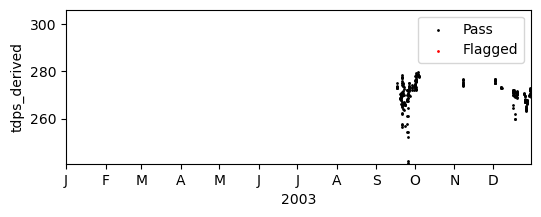

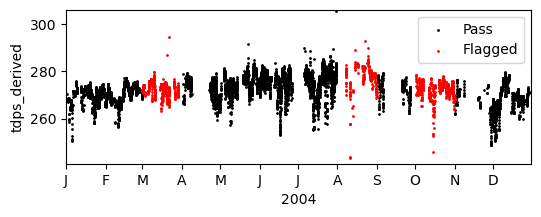

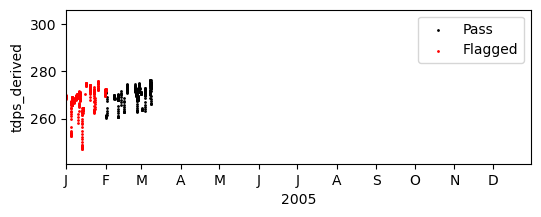

In [57]:
plot_gap_scatter(df, var='tdps_derived')

----
testing for part 2 below

In [ ]:
## part2 

# compare all observations in a single month, all years
# histogram created from all obs and gaussian distribution is fitted
# threshold values are determined using positions where fitted frequency falls below y=0.1
# and rounding outwards to the next integer plus one
# going outwards from center, distribution is scanned for gaps which occur outside threshold value
# obs beyond gap are flagged


## gaussian distribution may not be a perfect fit for bulk of obs, with thresholds too high
## allow for non-zero skew and kurtosis by using gauss-hermite series
## updated thresholds occur closer to bulk of distribution curve

#--------------------------------------------------------------------------------------
# intention is to have a function like: 

# def qaqc_dist_gaps_check(df, plot=False):
#     if plot=True:
#         plot_gap_check(df, var) # etc. 

In [ ]:
# identify the actual data vars
vars_to_remove = ['duration', 'method', 'lat', 'lon', 'elevation', 'qc', 'station', 'time', 'month', 'year']
[d for d in df.columns if not any(True for item in vars_to_remove if item in d)]

In [ ]:
def plot_gap_check(df, var):
    # plot histogram with count values against the standardized IQR
    num_bins = int(df[var].max()) + 1 - int(df[var].min())
    N = 10000 # what is this number - it matters!
    
    # standardize against IQR range
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    df_month_iqr = (df[var].values - df[var].median()) / iqr
    
    x = df_month_iqr
    plt.hist(x, bins=num_bins, alpha=0.3);
    xmin, xmax = plt.xlim()
    
    kur = stats.kurtosis(x, fisher=True)
    sk = stats.skew(x)

    # plot pdf
    if var == 'tas' or var == 'tdps' or var =='tdps_derived':
#         plt.xlim([-5,5])
        y = np.linspace(-5, 5, num_bins)
    else:
        y = np.linspace(xmin, xmax, num_bins)
    bin_width = (x.max() - x.min()) / num_bins
    plt.plot(y, stats.norm.pdf(y) * N * bin_width, color='k', lw=1)

    # add vertical lines to indicate thresholds -- clearly not correct
    pdf_idx = list(filter(lambda i: i > 0.1, stats.norm.pdf(y)))
    plt.axvline(x=y[stats.norm.pdf(y).tolist().index(pdf_idx[0])], color='r') # left tail
    plt.axvline(y[stats.norm.pdf(y).tolist().index(pdf_idx[-1])], color='r') # right tail
    
    plt.gca().set_yscale('log')

    # flag (visually) obs that are beyond threshold
    # bar_value_to_label = -2.25
    # patch_index = np.digitize([bar_value_to_label], x)[0]
    # hh.patches[patch_index].set_color('r')
    # hh.patches[patch_index].set_alpha(1)

    # title and useful annotations
    plt.title('QA/QC Distributional gap for {0}: {1}'.format(df_month['station'].unique()[0], var));
    plt.annotate('Month: {}'.format(m), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10);
    plt.annotate('Mean: {}'.format(round(np.nanmean(df_month_iqr),3)), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8);
    plt.annotate('Std.Dev: {}'.format(round(np.nanstd(df_month_iqr),3)), xy=(0.05, 0.85), xycoords='axes fraction', fontsize=8);
    plt.annotate('Skew: {}'.format(round(sk,3)), xy=(0.05,0.8), xycoords='axes fraction', fontsize=8)
    plt.annotate('Kurtosis: {}'.format(round(kur,3)), xy=(0.05, 0.75), xycoords='axes fraction', fontsize=8)
    plt.ylabel('Frequency (obs)')
    plt.xlabel('{} offset (IQR)'.format(var));
    
    # put AWS save figure stuffs here
    
    return

In [ ]:
m = 2
df_month = df.loc[df['month'] == m]

plot_gap_check(df_month, var='tas')

In [ ]:
# # identifying where pdf curve is below 0.1 threshold

# pdf_idx = list(filter(lambda i: i > 0.1, stats.norm.pdf(y).tolist()))
# pdf_idx